In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tskit as tsk
 
from bgspy.models import BGSModel
from bgspy.genome import Genome
from bgspy.utils import bin_chrom
from bgspy.data import GenomeData, pi_from_pairwise_summaries, trimmed_bins
from bgspy.sim_utils import mutate_simulated_tree
from bgspy.likelihood import FreeMutationModel

2022-09-01 00:12:48.402912: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
plt.style.use('./buffalo.mplstyle')
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

In [4]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
#g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
#g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

In [5]:
file = '../data/chrombgs_chr10_thresh0_N1000_mu3.16e-09_sh0.0316_chr10_seed1519291738_rep1_treeseq.tree'
file1 = '../data/chrombgs_chr10_thresh0_N10k_N10000_mu1e-08_sh0.01_chr10_seed3290190163_rep70_treeseq.tree'
file2 = '../data/chrombgs_chr10_thresh0_N10k_N10000_mu1e-08_sh0.01_chr10_seed3686382922_rep69_treeseq.tree'
file2 = '../data/chrombgs_chr10_merged_N1000_mu1e-08_sh0.01_chr10_seed3004617362_rep9_treeseq.tree'
file2 = '../data/chrombgs_chr10_merged_phastcons_N1000_mu1e-08_sh0.01_chr10_seed2129849082_rep44_treeseq.tree'
ts = tsk.load(file2)

In [6]:
#pkl_b_file= '../data/bmaps/bgspy/bmap_hg38_sims_10000step_chr10.pkl'
pkl_b_file= '../data/bmaps/bgspy/bmap_hg38_6x5grid_10000step_10000N_genomiconly.pkl'
m = BGSModel.load(pkl_b_file)

In [7]:
# simulation data
gd = GenomeData(g)
gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [8]:
gd.load_counts_from_ts(mutate_simulated_tree(ts, rate=1e-7), chrom='chr10')

Load real genomic data for comparison (e.g. to see how sims compare).

In [9]:
hg38_gd = GenomeData(g)
hg38_gd.load_counts_dir('../data/h1kg/hg1k_counts/')
hg38_gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
hg38_gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [10]:
hg38_bins, hg38_pi = hg38_gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

In [11]:
winsize = 1_000_000

_, pi = gd.bin_pi(winsize)
bins, Y = gd.bin_reduce(winsize, merge=True)
trim_bins, trim_Y, trim_idx = trimmed_bins(Y, bins, (0.0, 0.99))

In [12]:
Bo = np.concatenate([m.BScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)
Bpo = np.concatenate([m.BpScores.bin_means(bins).B[c] for c in bins.bins.keys()], axis=0)

B, Bp = Bo[trim_idx, :], Bpo[trim_idx, :]

(array([1112.29930712,    0.        , 5561.49653559, 4449.19722847,
        4449.19722847, 9454.5441105 , 5005.34688203, 6673.79584271,
        7786.09514982, 3336.89792135, 3893.04757491,  556.14965356,
        3336.89792135, 3893.04757491, 3893.04757491, 2224.59861424,
        2780.74826779, 1668.44896068, 2224.59861424,  556.14965356]),
 array([4.45800445e-05, 5.83058245e-05, 7.20316045e-05, 8.57573845e-05,
        9.94831645e-05, 1.13208944e-04, 1.26934724e-04, 1.40660504e-04,
        1.54386284e-04, 1.68112064e-04, 1.81837844e-04, 1.95563624e-04,
        2.09289404e-04, 2.23015184e-04, 2.36740964e-04, 2.50466744e-04,
        2.64192524e-04, 2.77918304e-04, 2.91644084e-04, 3.05369864e-04,
        3.19095644e-04]),
 <BarContainer object of 20 artists>)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


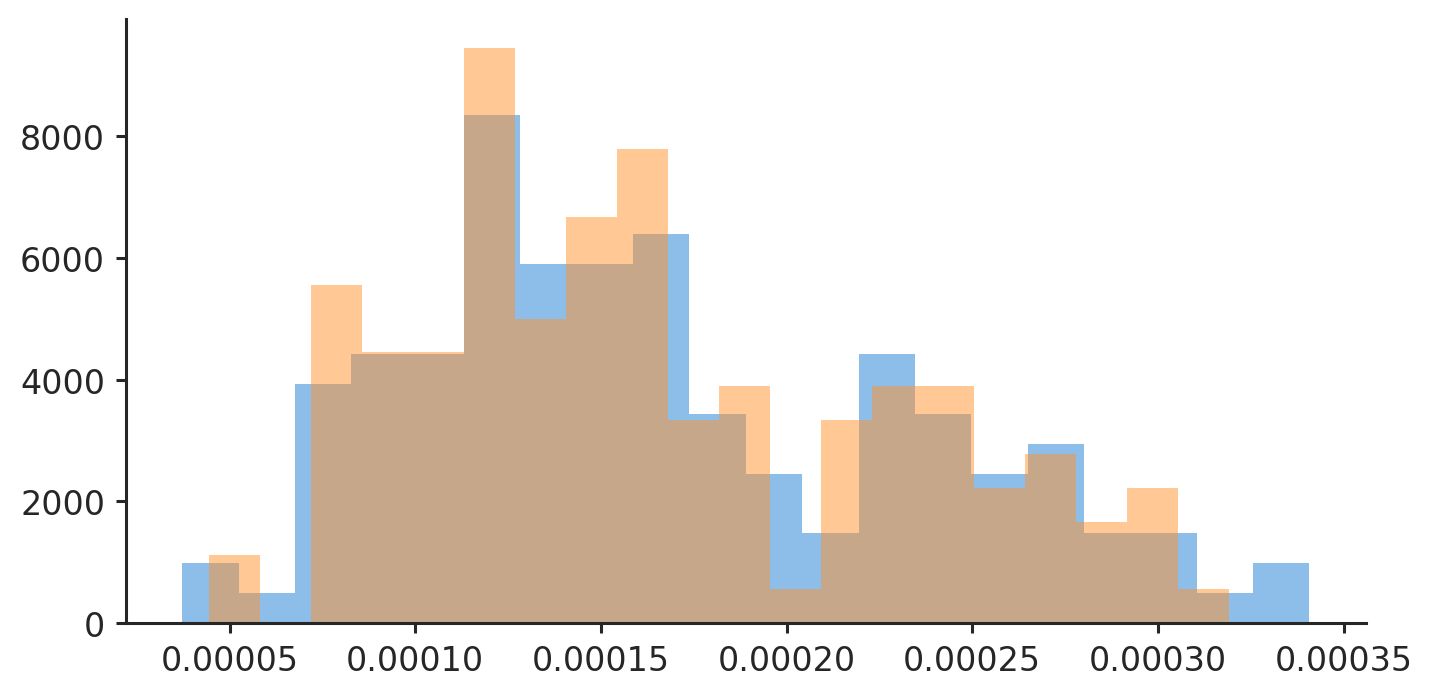

In [13]:
plt.hist(pi['chr10'].stat, 20, density=True, alpha=0.5)
plt.hist(pi_from_pairwise_summaries(trim_Y), 20, density=True, alpha=0.5)

In [14]:
ts_bins = bin_chrom(ts.sequence_length, winsize)
bm_pi = ts.diversity(mode='branch', windows=ts_bins)
ts_midpoints = (ts_bins[1:]+ts_bins[:-1])/2

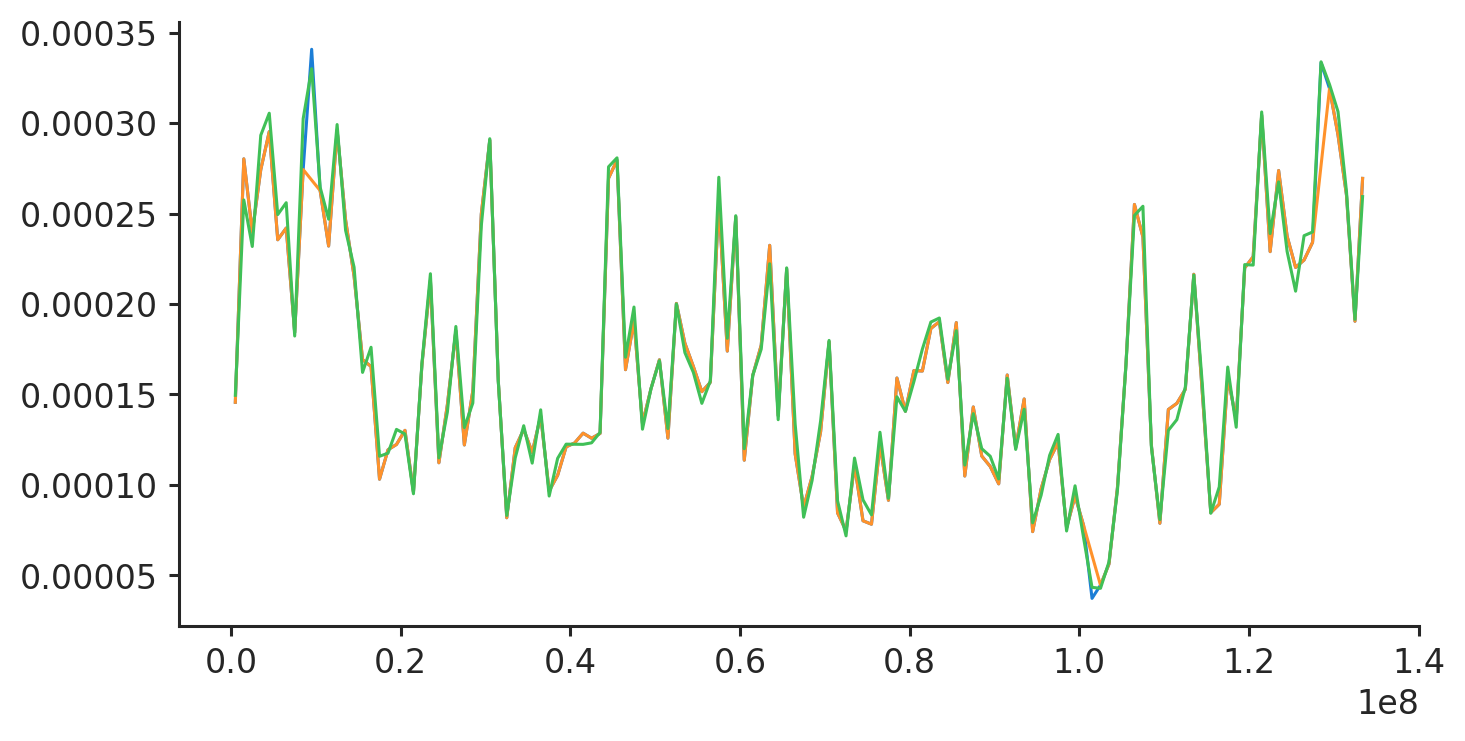

In [15]:
plt.plot(*pi['chr10'].pairs)

midpoints = [(s+e)/2 for c, s, e in trim_bins]
plt.plot(midpoints, pi_from_pairwise_summaries(trim_Y))

plt.plot(ts_midpoints, bm_pi * 1e-7)

In [16]:
m.t

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

In [17]:
#np.random.seed(1)

#w, t = m.w, m.t
w = m.w
t = np.logspace(-4, -1, 4)
#lik_nml = FreeMutationModel(w, t, Bp[:, :, [0, 2, 4, 6], :], Y=trim_Y)
lik_nml = FreeMutationModel(m.w, m.t, Bp, Y=trim_Y)
lik_nml.fit(starts=10000, ncores=70, algo='NELDERMEAD')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:01<00:00, 55.09it/s]


In [18]:
lik_nml

MLE (interpolated w): 6 x 5 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 418136637047.6707
π0 = 0.0003475477353616968
W = 
---------  ----------  -----------
0.0392471  0.00161665  0.202215
0.0163865  0.00143714  0.00018666
0.0149207  0.0839899   0.000228776
0.178431   0.452163    0.486237
0.751015   0.460793    0.311132
---------  ----------  -----------
μ = 
-----------  -----------  -----------
7.09472e-10  6.95829e-09  1.04257e-07
-----------  -----------  -----------

In [19]:
lik_nml.theta_

array([3.47547735e-04, 2.78447516e-11, 1.12491149e-11, 2.10824651e-08,
       1.16257632e-11, 1.00000000e-11, 1.94607286e-11, 1.05858103e-11,
       5.84425923e-10, 2.38516421e-11, 1.26591565e-10, 3.14628248e-09,
       5.06938321e-08, 5.32824120e-10, 3.20632874e-09, 3.24378687e-08])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


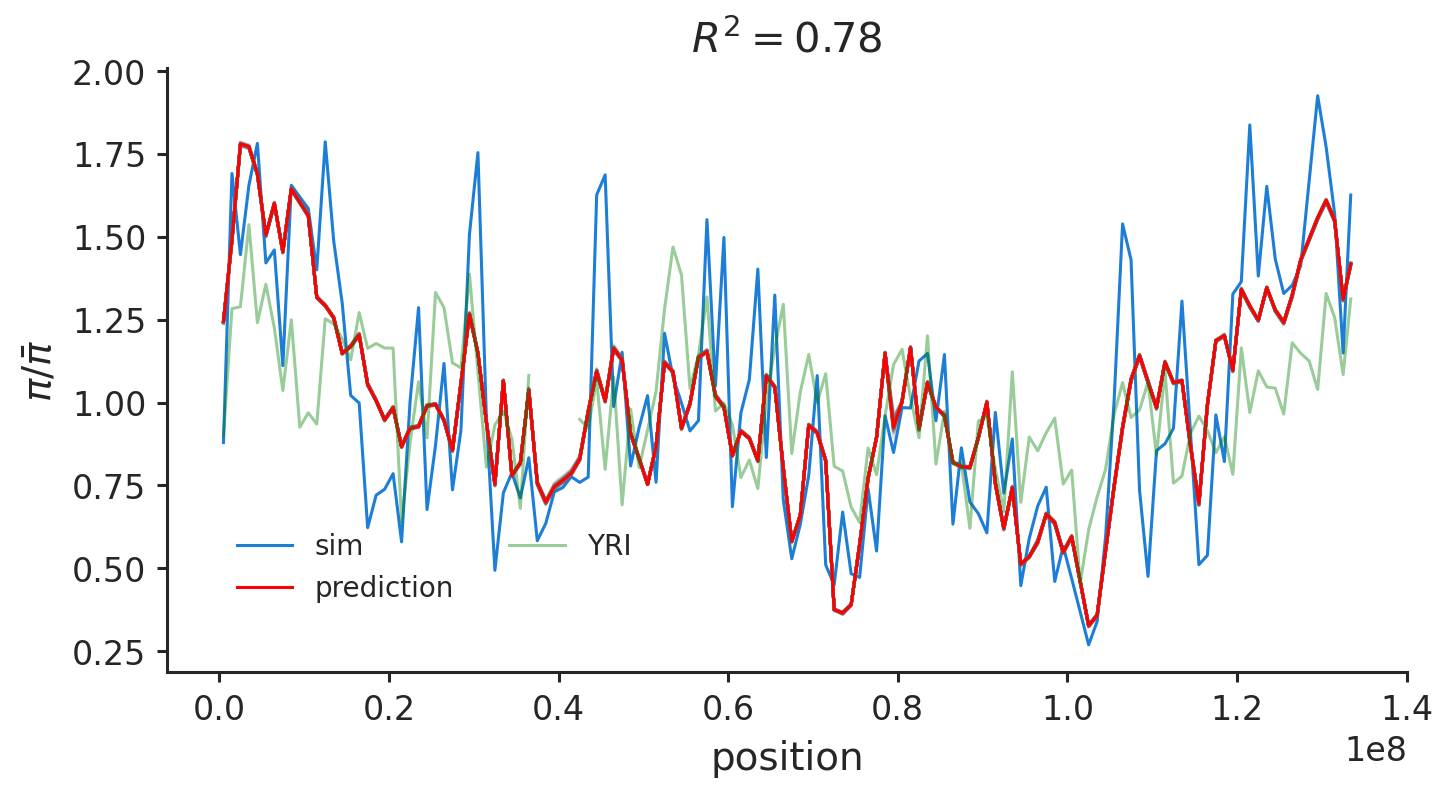

In [20]:
def ratio(x):
    return x/np.nanmean(x)


#plt.plot(ratio(pi['chr10'].pairs[1]))

midpoints = [(s+e)/2 for c, s, e in trim_bins]
#plt.scatter(midpoints, ratio(pi_from_pairwise_summaries(trim_Y)), s=5)
plt.plot(midpoints, ratio(pi_from_pairwise_summaries(trim_Y)), label='sim')


for i in range(100):
    plt.plot(midpoints, ratio(lik_nml.predict(optim=i)), c='0.44', alpha=0.1)
    
plt.plot(midpoints, ratio(lik_nml.predict()), c='r', label='prediction')

hg38_x, hg38_y = hg38_pi['chr10'].pairs
plt.plot(hg38_x, ratio(hg38_y), c='g', alpha=0.4, label='YRI')
plt.ylabel("$\pi/\\bar{\pi}$")
plt.xlabel("position")
plt.title(f"$R^2 = {lik_nml.R2():.2}$")
plt.legend(loc='lower left', ncol=2)

In [21]:
W = lik_nml.optim.thetas_[:100].mean(axis=0)[1:].reshape((5, 3))
W

array([[3.03693655e-10, 3.72279824e-11, 1.77208800e-08],
       [2.42635857e-11, 1.15701842e-11, 1.55582155e-10],
       [4.33418845e-11, 5.77958695e-10, 1.85709996e-10],
       [1.71478515e-10, 3.15962501e-09, 4.99432965e-08],
       [7.63576580e-10, 3.12951320e-09, 3.42639107e-08]])

In [22]:
lik_nml.R2()

0.7834615757438393

In [23]:
lik_nml

MLE (interpolated w): 6 x 5 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 418136637047.6707
π0 = 0.0003475477353616968
W = 
---------  ----------  -----------
0.0392471  0.00161665  0.202215
0.0163865  0.00143714  0.00018666
0.0149207  0.0839899   0.000228776
0.178431   0.452163    0.486237
0.751015   0.460793    0.311132
---------  ----------  -----------
μ = 
-----------  -----------  -----------
7.09472e-10  6.95829e-09  1.04257e-07
-----------  -----------  -----------

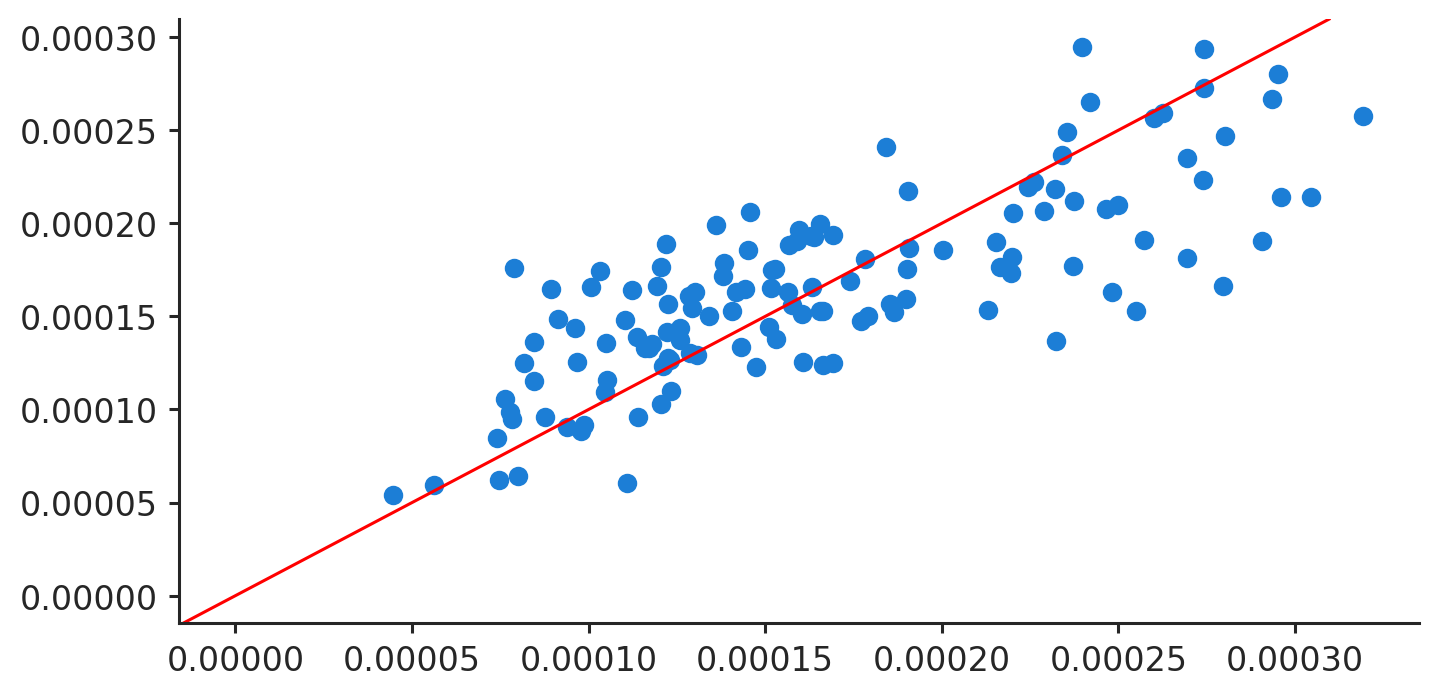

In [24]:
plt.scatter(pi_from_pairwise_summaries(trim_Y), lik_nml.predict())
plt.axline((0, 0), slope=1, c='r')